In [1]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline

In [3]:
df = pd.read_csv('data/ratings.csv')
ratings = df.pivot(index='userId', columns='movieId', values='rating')
ratings.shape

(610, 9724)

Dimensionality Reduction

In [4]:
user_ratings_threshold = ratings.count(axis=1).quantile(0.1)
movie_ratings_threshold = ratings.count(axis=0).quantile(0.1)
user_ratings_threshold, movie_ratings_threshold

(24.0, 1.0)

In [5]:
ratings_matrix = ratings.dropna(thresh=user_ratings_threshold, axis=0).dropna(thresh=movie_ratings_threshold, axis=1)  # Discard data of low importance
ratings_matrix.shape

(554, 9713)

In [6]:
# Prepare data for SVD
# ratings_matrix_filled = ratings_matrix.fillna(2.5)  # majority of df characteristics will incline to the const (2.5)
# ratings_matrix_filled = ratings_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)  # critical points have great error
ratings_matrix_filled = ratings_matrix.apply(lambda col: col.fillna(col.mean()), axis=0)  # closest to the truth

R = ratings_matrix_filled.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [7]:
U, singular_values, Vt = svds(R_demeaned, k=3)  # k is the number of latent features
# 2 – .04 error; 3 – .02 error; 5 – .01 error
S = np.diag(singular_values)

Visalization of the latent features

Text(0.5, 0.92, 'Users')

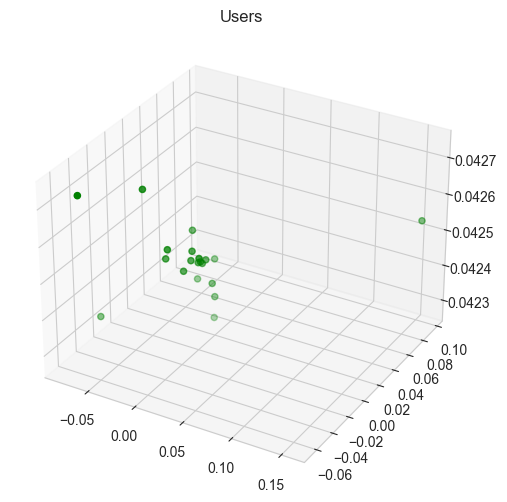

In [8]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(*U.T[:, :20], c='g', marker='o')  # discard users with similar criteria
ax.set_title('Users')

Text(0.5, 0.92, 'Movies')

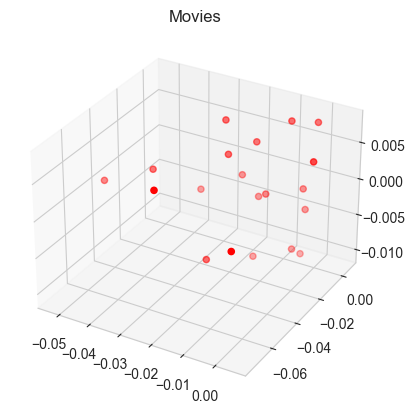

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*Vt[:, :20], c='r', marker='o')  # plot Vt.T = V discarding similar movies
ax.set_title('Movies')

Predictions

In [10]:
ratings_svd = np.dot(np.dot(U, S), Vt) + user_ratings_mean.reshape(-1, 1)
ratings_matrix_svd = pd.DataFrame(ratings_svd, columns=ratings_matrix.columns, index=ratings_matrix.index)

In [11]:
ratings_matrix_svd_info = ratings_matrix_svd.apply(lambda x: x.describe(), axis=1)
ratings_matrix_svd_info

,count,mean,std,min,25%,50%,75%,max
userId,,,,,,,,
1,9713.0,3.280862,0.875557,0.496105,2.819850,3.465481,3.952498,5.009562
2,9713.0,3.261599,0.869291,0.500368,2.791923,3.416932,3.908677,5.000334
3,9713.0,3.256948,0.867689,0.502138,2.787396,3.408697,3.897691,4.996302
4,9713.0,3.257227,0.868381,0.502109,2.787599,3.402605,3.896322,5.002831
5,9713.0,3.261234,0.869313,0.500472,2.789505,3.415931,3.904921,5.001583
...,...,...,...,...,...,...,...,...
606,9713.0,3.269802,0.868196,0.514381,2.798887,3.415386,3.910569,5.011746
607,9713.0,3.266923,0.868163,0.507734,2.803947,3.430049,3.918908,4.996908
608,9713.0,3.248603,0.875509,0.494392,2.759677,3.385818,3.911866,5.002399


In [12]:
ratings_matrix_filled_info = ratings_matrix_filled.apply(lambda x: x.describe(), axis=1)
ratings_matrix_filled_info

,count,mean,std,min,25%,50%,75%,max
userId,,,,,,,,
1,9713.0,3.280862,0.890263,0.5,2.800000,3.437500,3.986111,5.0
2,9713.0,3.261599,0.870204,0.5,2.789474,3.416667,3.909091,5.0
3,9713.0,3.256948,0.879419,0.5,2.777778,3.416667,3.910000,5.0
4,9713.0,3.257227,0.887014,0.5,2.750000,3.400000,3.928571,5.0
5,9713.0,3.261234,0.871372,0.5,2.785714,3.416667,3.916667,5.0
...,...,...,...,...,...,...,...,...
606,9713.0,3.269802,0.888699,0.5,2.750000,3.454545,4.000000,5.0
607,9713.0,3.266923,0.879191,0.5,2.800000,3.416667,3.937500,5.0
608,9713.0,3.248603,0.909656,0.5,2.750000,3.426829,4.000000,5.0


Recommendations

In [13]:
predicted_user_ratings = ratings_matrix_svd.where(ratings_matrix.isnull())
ratings_matrix.count().sum() == predicted_user_ratings.isna().sum().sum()  # verify the amount of predicted data

True

In [14]:
movies = pd.read_csv("data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
def recommend_movies(user_id):
    recommended_movies_id = predicted_user_ratings.loc[user_id].sort_values(ascending=False)[:10].index.tolist()
    return movies[movies['movieId'].isin(recommended_movies_id)].reset_index()[["title", "genres"]]

In [16]:
recommend_movies(1)

,title,genres
0,Supercop 2 (Project S) (Chao ji ji hua) (1993),Action|Comedy|Crime|Thriller
1,Two Family House (2000),Drama
2,"Son of the Bride (Hijo de la novia, El) (2001)",Comedy|Drama
3,"Thousand Clowns, A (1965)",Comedy|Drama|Romance
4,"Marriage of Maria Braun, The (Ehe der Maria Br...",Drama
5,7 Faces of Dr. Lao (1964),Fantasy|Mystery|Western
6,Hellbenders (2012),Comedy|Horror|Thriller
7,National Lampoon's Bag Boy (2007),Comedy
8,Tom Segura: Mostly Stories (2016),Comedy
9,Moonlight,Drama


In [17]:
recommend_movies(443)

,title,genres
0,Bossa Nova (2000),Comedy|Drama|Romance
1,Vagabond (Sans toit ni loi) (1985),Drama
2,Animals are Beautiful People (1974),Comedy|Documentary
3,Jane Eyre (1944),Drama|Romance
4,Tales of Manhattan (1942),Comedy|Drama
5,9/11 (2002),Documentary
6,Peaceful Warrior (2006),Drama
7,Tom Segura: Completely Normal (2014),Comedy
8,George Carlin: It's Bad for Ya! (2008),Comedy
9,George Carlin: Life Is Worth Losing (2005),Comedy


In [18]:
recommend_movies(69)

,title,genres
0,Knock Off (1998),Action
1,When Worlds Collide (1951),Sci-Fi
2,"Passenger, The (Professione: reporter) (1975)",Drama
3,Che: Part One (2008),Drama|War
4,Che: Part Two (2008),Drama|War
5,"Very Potter Sequel, A (2010)",Comedy|Musical
6,Into the Forest of Fireflies' Light (2011),Animation|Drama|Fantasy
7,Dragons: Gift of the Night Fury (2011),Adventure|Animation|Comedy
8,Cosmic Scrat-tastrophe (2015),Animation|Children|Comedy
9,The Girls (1961),Comedy|Romance
